In [16]:
# Rohitash Chandra, 2017 c.rohitash@gmail.conm

#https://github.com/rohitash-chandra
 

# ref: http://iamtrask.github.io/2015/07/12/basic-python-network/  
 

#Sigmoid units used in hidden and output  

# Numpy used: http://cs231n.github.io/python-numpy-tutorial/#numpy-arrays
 
# this version will demonstrate momemntum and stocastic gradient descent 

#FNN for Time Series prediction and Regression
 

import matplotlib.pyplot as plt
import numpy as np 
import random
import time
import pandas as pd
 
class Network:

	def __init__(self, Topo, Train, Test, MaxTime,  MinPer, learnRate, use_stocasticGD, use_vanillalearning,  momentum_rate): 
		self.Top  = Topo  # NN topology [input, hidden, output]
		self.Max = MaxTime # max epocs
		self.TrainData = Train
		self.TestData = Test
		self.NumSamples = Train.shape[0]

		self.learn_rate  = learnRate
 

		self.minPerf = MinPer
		
		#initialize weights ( W1 W2 ) and bias ( b1 b2 ) of the network
		np.random.seed() 
		self.W1 = np.random.uniform(-0.5, 0.5, (self.Top[0] , self.Top[1]))  
		#print(self.W1,  ' self.W1')
		self.B1 = np.random.uniform(-0.5,0.5, (1, self.Top[1])  ) # bias first layer
		#print(self.B1, ' self.B1')
		self.BestB1 = self.B1
		self.BestW1 = self.W1 
		self.W2 = np.random.uniform(-0.5, 0.5, (self.Top[1] , self.Top[2]))   
		self.B2 = np.random.uniform(-0.5,0.5, (1,self.Top[2]))  # bias second layer
		self.BestB2 = self.B2
		self.BestW2 = self.W2 
		self.hidout = np.zeros(self.Top[1] ) # output of first hidden layer
		self.out = np.zeros(self.Top[2]) #  output last layer

		self.hid_delta = np.zeros(self.Top[1] ) # output of first hidden layer
		self.out_delta = np.zeros(self.Top[2]) #  output last layer

		self.vanilla = use_vanillalearning  # canonical batch training mode - use full data set - no SGD  

		self.momenRate = momentum_rate

		self.stocasticGD = use_stocasticGD




	def sigmoid(self,x):
		return 1 / (1 + np.exp(-x))

	
	def softmax(self, x):
		# Numerically stable with large exponentials
		exps = np.exp(x - x.max())
		return exps / np.sum(exps, axis=0)

	def sampleEr(self,actualout):
		error = np.subtract(self.out, actualout)
		sqerror= np.sum(np.square(error))/self.Top[2] 
		 
		return sqerror

	def ForwardPass(self, X ): 
		z1 = X.dot(self.W1) - self.B1  
		self.hidout = self.sigmoid(z1) # output of first hidden layer   
		z2 = self.hidout.dot(self.W2)  - self.B2 
		self.out = self.sigmoid(z2)  # output second hidden layer



	def BackwardPass(self, input_vec, desired):   
		out_delta =   (desired - self.out)*(self.out*(1-self.out))  
		hid_delta = out_delta.dot(self.W2.T) * (self.hidout * (1-self.hidout)) 
		#https://www.tutorialspoint.com/numpy/numpy_dot.htm  https://www.geeksforgeeks.org/numpy-dot-python/
  
		if self.vanilla == True: #no momentum 
			self.W2+= self.hidout.T.dot(out_delta) * self.learn_rate
			self.B2+=  (-1 * self.learn_rate * out_delta)

			self.W1 += (input_vec.T.dot(hid_delta) * self.learn_rate) 
			self.B1+=  (-1 * self.learn_rate * hid_delta) 
		else: # use momentum
			v2 = self.W2.copy() #save previous weights http://cs231n.github.io/neural-networks-3/#sgd
			v1 = self.W1.copy()
			b2 = self.B2.copy()
			b1 = self.B1.copy()

			self.W2+= ( v2 *self.momenRate) + (self.hidout.T.dot(out_delta) * self.learn_rate)       # velocity update
			self.W1 += ( v1 *self.momenRate) + (input_vec.T.dot(hid_delta) * self.learn_rate)   
			self.B2+= ( b2 *self.momenRate) + (-1 * self.learn_rate * out_delta)       # velocity update
			self.B1 += ( b1 *self.momenRate) + (-1 * self.learn_rate * hid_delta)   
  
			
 
	def TestNetworkRegression(self, Data,  erTolerance):
		Input = np.zeros((1, self.Top[0])) # temp hold input
		Desired = np.zeros((1, self.Top[2])) 
		nOutput = np.zeros((1, self.Top[2]))
		testSize = Data.shape[0] 
		sse = 0  
		Input = np.zeros((1, self.Top[0])) # temp hold input

        #CHange
		predicted = np.zeros((testSize,self.Top[2]))

		self.W1 = self.BestW1
		self.W2 = self.BestW2 #load best knowledge
		self.B1 = self.BestB1
		self.B2 = self.BestB2 #load best knowledge
 
		for s in range(0, testSize):
							
			Input[:]  =   Data[s,0:self.Top[0]] 
			Desired[:] =  Data[s,self.Top[0]:] 

			self.ForwardPass(Input) 
			predicted[s] = self.out

			sse = sse+ self.sampleEr(Desired)   

		actual =  Data[:,self.Top[0]:]  



		return np.sqrt(sse/testSize),   actual, predicted




	def saveKnowledge(self):
		self.BestW1 = self.W1
		self.BestW2 = self.W2
		self.BestB1 = self.B1
		self.BestB2 = self.B2 

		#print (self.BestW1, self.BestW2, self.BestB1, self.BestB2)

	def BP_GD(self, trainTolerance):  


		Input = np.zeros((1, self.Top[0])) # temp hold input
		Desired = np.zeros((1, self.Top[2])) 

		minibatchsize = int(0.1* self.TrainData.shape[0]) # choose a mini-batch size for SGD

		er = [] # collect error over time
		epoch = 0
		bestRMSE= 10000 # assign a large number in begining to maintain best (lowest RMSE)
		bestTrain = 0
		while  epoch < self.Max and bestTrain < self.minPerf :
			sse = 0

			if(self.stocasticGD==True): # create a minibatch of samples 
				train_dat = np.array(self.TrainData).tolist()
				array = []
				for iteratable in range (0, minibatchsize):
					pat = random.randint(0, len(self.TrainData)-1) # construst a mini-batch for SGD
					array.append(train_dat[pat])		   	
				train_dat = np.asarray(array)
				num_batch = 10 # because your batch size is 10 %, you need 10 batches to cover full data approximately
			else:
				train_dat = self.TrainData
				num_batch = 1

			#print(train_dat)

			for batch in range(0, num_batch): # 10 mini batches in case of SGD. 1 major batch in case of GD

				for s in range(0, train_dat.shape[0]):
			
					Input[:]  =  train_dat[s,0:self.Top[0]]  
					Desired[:]  = train_dat[s,self.Top[0]:]  

					self.ForwardPass(Input)  
					self.BackwardPass(Input ,Desired)
					sse = sse+ self.sampleEr(Desired)
			 
			rmse = np.sqrt(sse/self.TrainData.shape[0]*self.Top[2])

			if rmse < bestRMSE:
				 bestRMSE = rmse
				 self.saveKnowledge() 
				 bestRMSE, actual, predicted = self.TestNetworkRegression(self.TrainData,   trainTolerance)
				 #print(bestRMSE )

			er = np.append(er, rmse)
			
			epoch=epoch+1  

		return (er, bestRMSE,  epoch, actual, predicted) 

In [17]:
def normalisedata(data, inputsize, outsize): # normalise the data between [0,1]
	traindt = data[:,np.array(range(0,inputsize))]	
	dt = np.amax(traindt, axis=0)
	tds = abs(traindt/dt) 
	return np.concatenate(( tds[:,range(0,inputsize)], data[:,range(inputsize,inputsize+outsize)]), axis=1)

Lazer
0  is experimental run
1  is experimental run
2  is experimental run
3  is experimental run
4  is experimental run
5  is experimental run
6  is experimental run
7  is experimental run
8  is experimental run
9  is experimental run
10  is experimental run
11  is experimental run
12  is experimental run
13  is experimental run
14  is experimental run
15  is experimental run
16  is experimental run
17  is experimental run
18  is experimental run
19  is experimental run
20  is experimental run
21  is experimental run
22  is experimental run
23  is experimental run
24  is experimental run
25  is experimental run
26  is experimental run
27  is experimental run
28  is experimental run
29  is experimental run
RMSE performance for each experimental run
[0.20425251 0.20496604 0.20506465 0.20402049 0.20495314 0.2050117
 0.20377149 0.20567302 0.20436296 0.20418852 0.20355474 0.20338064
 0.20347392 0.20470403 0.20419792 0.20484962 0.20532818 0.20501074
 0.20416486 0.20304398 0.20417803 0.20422

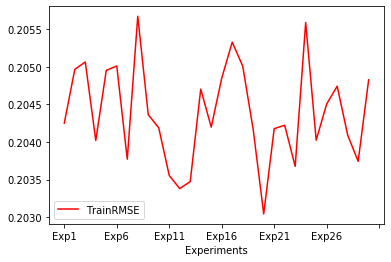

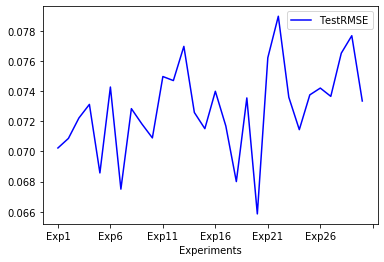

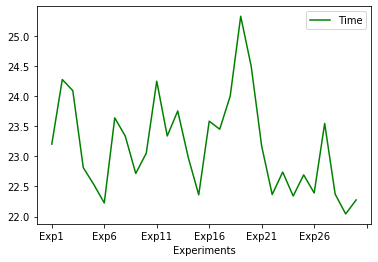

Sunspot
0  is experimental run
1  is experimental run
2  is experimental run
3  is experimental run
4  is experimental run
5  is experimental run
6  is experimental run
7  is experimental run
8  is experimental run
9  is experimental run
10  is experimental run
11  is experimental run
12  is experimental run
13  is experimental run
14  is experimental run
15  is experimental run
16  is experimental run
17  is experimental run
18  is experimental run
19  is experimental run
20  is experimental run
21  is experimental run
22  is experimental run
23  is experimental run
24  is experimental run
25  is experimental run
26  is experimental run
27  is experimental run
28  is experimental run
29  is experimental run
RMSE performance for each experimental run
[0.09403485 0.09493143 0.09210119 0.1002274  0.09320849 0.09722741
 0.08956255 0.09756926 0.09792643 0.09602049 0.09413154 0.09656542
 0.10034758 0.09362288 0.09093647 0.09734624 0.10125439 0.101999
 0.09474022 0.09586625 0.09787368 0.0952

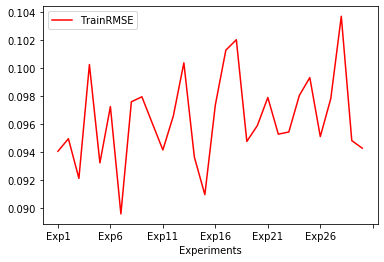

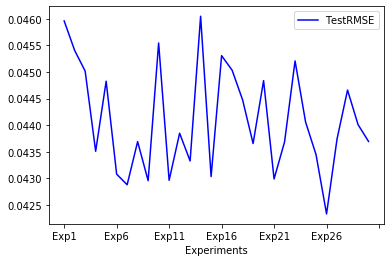

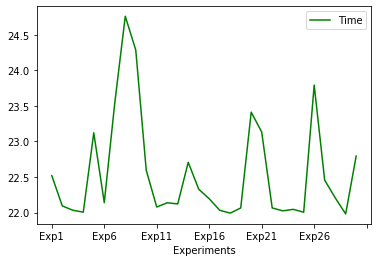

Mackey
0  is experimental run
1  is experimental run
2  is experimental run
3  is experimental run
4  is experimental run
5  is experimental run
6  is experimental run
7  is experimental run
8  is experimental run
9  is experimental run
10  is experimental run
11  is experimental run
12  is experimental run
13  is experimental run
14  is experimental run
15  is experimental run
16  is experimental run
17  is experimental run
18  is experimental run
19  is experimental run
20  is experimental run
21  is experimental run
22  is experimental run
23  is experimental run
24  is experimental run
25  is experimental run
26  is experimental run
27  is experimental run
28  is experimental run
29  is experimental run
RMSE performance for each experimental run
[0.09973554 0.09885385 0.09953495 0.10065271 0.09826103 0.09913123
 0.09891044 0.09859729 0.09869603 0.09919425 0.09806114 0.09863762
 0.09736718 0.09887806 0.09943074 0.09867146 0.09783723 0.0983641
 0.09896428 0.09869778 0.09767999 0.0986

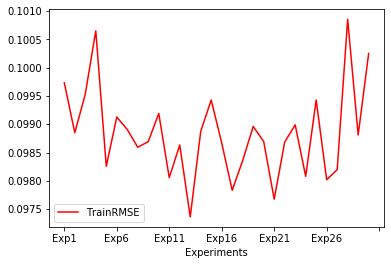

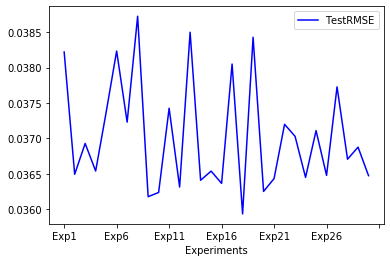

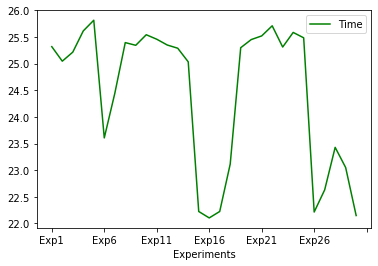

Lorenz
0  is experimental run
1  is experimental run
2  is experimental run
3  is experimental run
4  is experimental run
5  is experimental run
6  is experimental run
7  is experimental run
8  is experimental run
9  is experimental run
10  is experimental run
11  is experimental run
12  is experimental run
13  is experimental run
14  is experimental run
15  is experimental run
16  is experimental run
17  is experimental run
18  is experimental run
19  is experimental run
20  is experimental run
21  is experimental run
22  is experimental run
23  is experimental run
24  is experimental run
25  is experimental run
26  is experimental run
27  is experimental run
28  is experimental run
29  is experimental run
RMSE performance for each experimental run
[0.03441331 0.03714102 0.03794935 0.03727896 0.03474411 0.04720306
 0.04122656 0.03913884 0.04102156 0.04206585 0.0430081  0.04374889
 0.0364491  0.03842427 0.03713556 0.03714994 0.03873655 0.04441662
 0.04318801 0.03209469 0.04368214 0.047

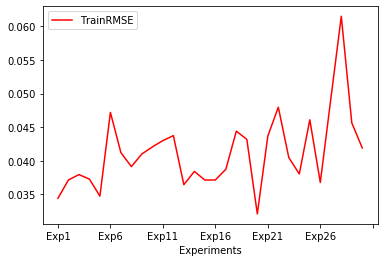

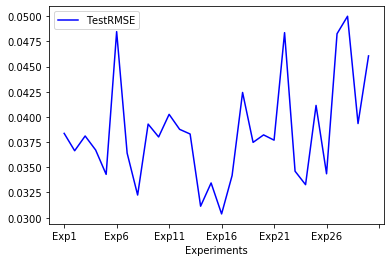

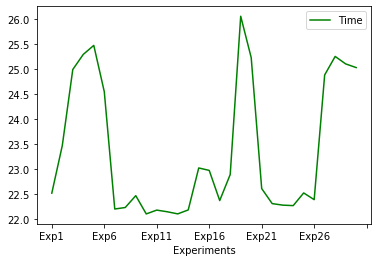

Rossler
0  is experimental run
1  is experimental run
2  is experimental run
3  is experimental run
4  is experimental run
5  is experimental run
6  is experimental run
7  is experimental run
8  is experimental run
9  is experimental run
10  is experimental run
11  is experimental run
12  is experimental run
13  is experimental run
14  is experimental run
15  is experimental run
16  is experimental run
17  is experimental run
18  is experimental run
19  is experimental run
20  is experimental run
21  is experimental run
22  is experimental run
23  is experimental run
24  is experimental run
25  is experimental run
26  is experimental run
27  is experimental run
28  is experimental run
29  is experimental run
RMSE performance for each experimental run
[0.0635072  0.06276096 0.06438597 0.064676   0.06402741 0.06469198
 0.06254157 0.06506547 0.06405882 0.06276581 0.06364182 0.06620358
 0.06336067 0.06498558 0.06552573 0.06360538 0.0654633  0.06269308
 0.06463017 0.06361867 0.06379371 0.06

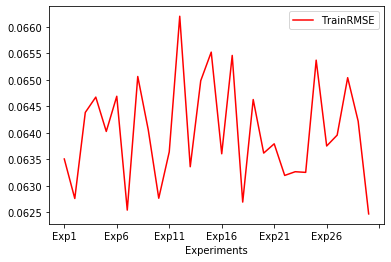

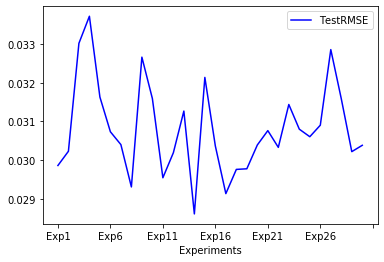

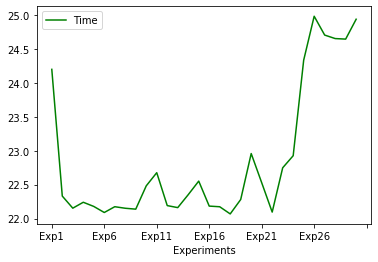

Henon
0  is experimental run
1  is experimental run
2  is experimental run
3  is experimental run
4  is experimental run
5  is experimental run
6  is experimental run
7  is experimental run
8  is experimental run
9  is experimental run
10  is experimental run
11  is experimental run
12  is experimental run
13  is experimental run
14  is experimental run
15  is experimental run
16  is experimental run
17  is experimental run
18  is experimental run
19  is experimental run
20  is experimental run
21  is experimental run
22  is experimental run
23  is experimental run
24  is experimental run
25  is experimental run
26  is experimental run
27  is experimental run
28  is experimental run
29  is experimental run
RMSE performance for each experimental run
[0.17875504 0.17904622 0.17983487 0.17936374 0.17954172 0.17907724
 0.17915604 0.17904024 0.17918276 0.1794267  0.17911816 0.17943839
 0.17913083 0.17927018 0.17920266 0.17914304 0.17881409 0.17904048
 0.17942869 0.17909004 0.179135   0.1792

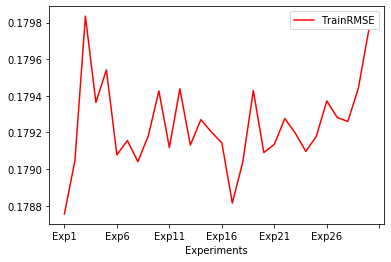

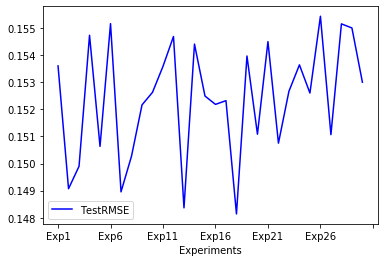

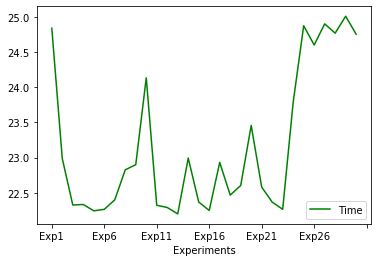

ACFinance
0  is experimental run
1  is experimental run
2  is experimental run
3  is experimental run
4  is experimental run
5  is experimental run
6  is experimental run
7  is experimental run
8  is experimental run
9  is experimental run
10  is experimental run
11  is experimental run
12  is experimental run
13  is experimental run
14  is experimental run
15  is experimental run
16  is experimental run
17  is experimental run
18  is experimental run
19  is experimental run
20  is experimental run
21  is experimental run
22  is experimental run
23  is experimental run
24  is experimental run
25  is experimental run
26  is experimental run
27  is experimental run
28  is experimental run
29  is experimental run
RMSE performance for each experimental run
[0.08768003 0.07430975 0.07759331 0.06787772 0.06149194 0.06155196
 0.08043342 0.08398928 0.0688747  0.07895671 0.08605542 0.07640297
 0.08745905 0.06531897 0.07755885 0.07393877 0.08500535 0.07870206
 0.14707689 0.0825507  0.07800574 0.

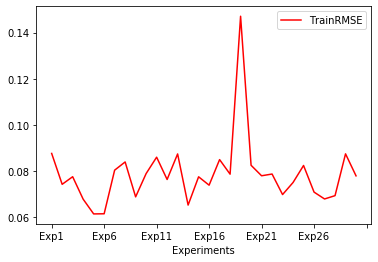

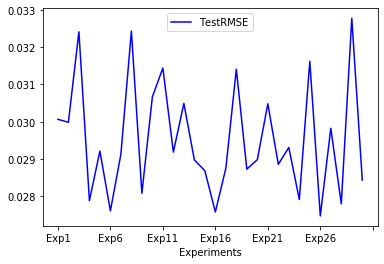

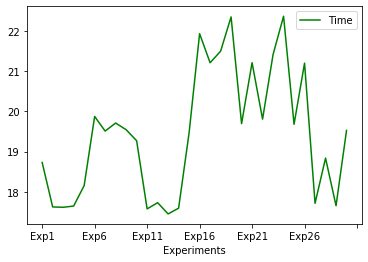

In [18]:
def main(): 


    for i in range(1, 8) : 

        problem = i
        if problem ==1:
            TrainData = pd.read_csv("../../data/Lazer/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../../data/Lazer/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Lazer"
        if problem ==2:
            TrainData = pd.read_csv("../../data/Sunspot/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../../data/Sunspot/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Sunspot"
        if problem ==3:
            TrainData = pd.read_csv("../../data/Mackey/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../../data/Mackey/test1.csv",index_col = 0)
            TestData = TestData.values
            name="Mackey"
        if problem ==4:
            TrainData = pd.read_csv("../../data/Lorenz/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../../data/Lorenz/test1.csv",index_col = 0)
            TestData = TestData.values  
            name= "Lorenz"
        if problem ==5:
            TrainData = pd.read_csv("../../data/Rossler/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../../data/Rossler/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Rossler"
        if problem ==6:
            TrainData = pd.read_csv("../../data/Henon/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../../data/Henon/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Henon"
        if problem ==7:
            TrainData = pd.read_csv("../../data/ACFinance/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../../data/ACFinance/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "ACFinance"  
        
        
        Hidden = 5
        Input = 5
        Output = 10 
        MaxTime = 1000
        MinCriteria = 100 #stop when learn 100 percent - to ensure it does not stop ( does not apply for time series - regression problems)


        Topo = [Input, Hidden, Output] 
        MaxRun = 30 # number of experimental runs 


        trainTolerance = 0.2 # [eg 0.15 would be seen as 0] [ 0.81 would be seen as 1]
        testTolerance = 0.49

        learnRate = 0.1  

        useStocastic = False # False for vanilla BP. True for Stocastic BP
        updateStyle = True # True for Vanilla (Canonical) Gradient Descent, False for Gradient Descent with momentum  

        momentum_rate = 0.001 # 0.1 ends up having very large weights. you can try and see




        trainRMSE =  np.zeros(MaxRun)
        testRMSE =  np.zeros(MaxRun)
        Epochs =  np.zeros(MaxRun)
        Time =  np.zeros(MaxRun)
        print(name)
        for run in range(0, MaxRun  ):
            print(run, ' is experimental run') 

            fnn = Network(Topo, TrainData, TestData, MaxTime,   MinCriteria, learnRate, useStocastic, updateStyle, momentum_rate)
            start_time=time.time()
            (erEp,  trainRMSE[run],  Epochs[run], actual, predicted) = fnn.BP_GD(trainTolerance)   


            Time[run]  =time.time()-start_time
            (testRMSE[run], actual, predicted) = fnn.TestNetworkRegression(TestData,  testTolerance) 


        
        print('RMSE performance for each experimental run') 
        print(trainRMSE)
        print(testRMSE)
        print('Epocs and Time taken for each experimental run') 
        print(Epochs)
        print(Time)
        print('mean and std of classification performance') 

        print(np.mean(trainRMSE), np.std(trainRMSE))
        print(np.mean(testRMSE), np.std(testRMSE))

        print(' print mean and std of computational time taken') 

        print(np.mean(Time), np.std(Time))
        arr = np.dstack((trainRMSE,testRMSE,Time,Epochs))
        arr=arr.reshape(MaxRun,4)
        print(arr)
        arr = pd.DataFrame(arr, index = [ 'Exp1','Exp2','Exp3','Exp4','Exp5','Exp6','Exp7','Exp8','Exp9','Exp10','Exp11','Exp12','Exp13','Exp14','Exp15','Exp16','Exp17','Exp18','Exp19','Exp20','Exp21','Exp22','Exp23','Exp24','Exp25','Exp26','Exp27','Exp28','Exp29','Exp30'], columns=['TrainRMSE','TestRMSE','Time','Epochs'])

        arr.to_csv("../../data/"+name+"/FNNscratchAnalysis/ExpAnalysis.csv") 

        arr1 = np.vstack(([np.mean(trainRMSE),np.std(trainRMSE),np.min(trainRMSE),np.max(trainRMSE)],[np.mean(testRMSE), np.std(testRMSE),np.min(testRMSE),np.max(testRMSE)],[np.mean(Time),np.std(Time),np.min(Time),np.max(Time)],[np.mean(Epochs),np.std(Epochs),np.min(Epochs),np.max(Epochs)]))
        arr1 = pd.DataFrame(arr1, index=['TrainRMSE','TestRMSE','Time','Epochs'], columns = ['Mean','Standard Deviation','Min','Max'])
        print(arr1)
        arr1.to_csv("../../data/"+name+"/FNNscratchAnalysis/OverallAnalysis.csv")

        ax = plt.gca()
        arr.plot(kind='line',x=None,y='TrainRMSE',color='red', ax=ax)
        plt.xlabel('Experiments') 
        plt.savefig("../../data/"+name+"/FNNscratchAnalysis/TrainRMSE.png",dpi=100)
        plt.show()

        ax = plt.gca()
        arr.plot(kind='line',x=None,y='TestRMSE',color='blue', ax=ax)
        plt.xlabel('Experiments') 
        plt.savefig("../../data/"+name+"/FNNscratchAnalysis/TestRMSE.png",dpi=100)
        plt.show()

        ax = plt.gca()
        arr.plot(kind='line',x=None,y='Time',color='green', ax=ax)
        plt.xlabel('Experiments') 
        plt.savefig("../../data/"+name+"/FNNscratchAnalysis/Time.png",dpi=100)
        plt.show()

 
if __name__ == "__main__": main()